# **1. Importing the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from collections import Counter
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# **2.Importing the dataset**

In [8]:
from google.colab import files

In [9]:
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [10]:
imdb_data = pd.read_csv("IMDB Dataset.csv")
print(imdb_data.shape)
imdb_data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **3.Exploratory Data Analysis**

**a.Handling the null values**

In [11]:
imdb_data.isna().any()

,0
review,False
sentiment,False


**b.Handling the duplicate values**

In [12]:
imdb_data['review'].nunique()

49582

In [13]:
# let's see duplicated reviews if any before preprocessing
duplicated_count = imdb_data.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [14]:
imdb_data['review'].drop_duplicates(inplace = True)

**c. Obtaining detailed information about the dataset**

In [20]:
# print the first 8 reviews

for i in range(8):
  print("Review number ",[i+1],"\n")
  print(imdb_data['review'].iloc[i+1], "\n")
  print("Sentiment: ", imdb_data['sentiment'].iloc[i+1], "\n\n")

Review number  [1] 

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are 

**d. Visualizing the class distribution using pie chart**

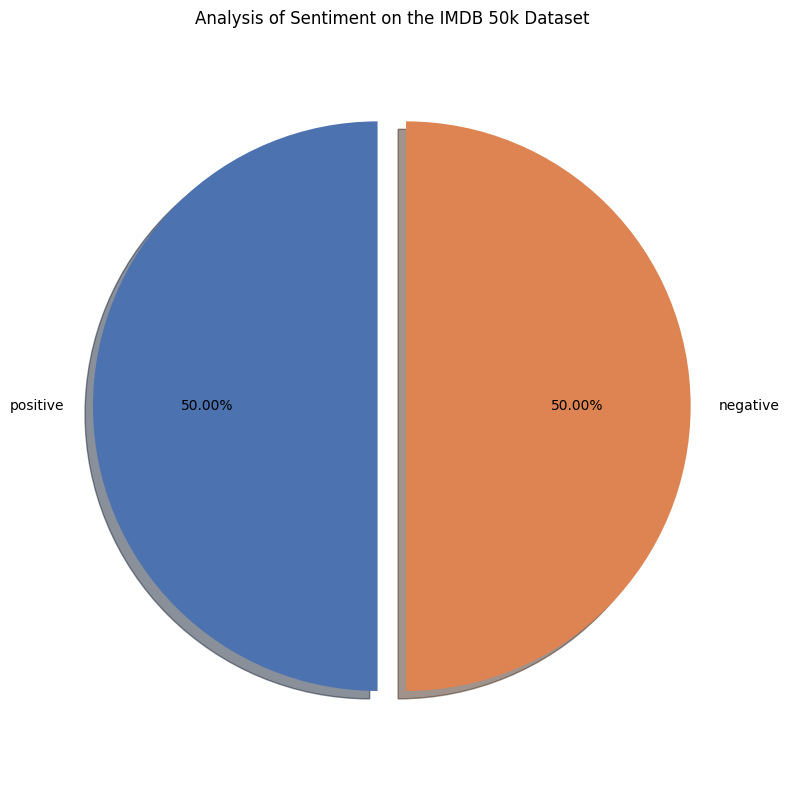

In [22]:
# Dataset information
colors = sns.color_palette('deep')

# Count the occurrences of each sentiment
sentiment_counts = imdb_data['sentiment'].value_counts()

# Prepare data for pie chart
labels = sentiment_counts.index
sizes = sentiment_counts.values
explode = (0.1, 0)  # explode the first slice (Positive)

# Create a pie chart
plt.figure(figsize=(8, 8), tight_layout=True)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90, colors=colors[:len(labels)])
plt.title('Analysis of Sentiment on the IMDB 50k Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save and show the pie chart
plt.savefig('sentiment_pie_chart.png')
plt.show()

**e. Investigating the number of words in each review**

In [23]:
# Defining a function to count number of words in each review
def count_words(text):
  words = text.split()
  num_words = len(words)
  return num_words

# To view the new table including word count
imdb_data['word count'] = imdb_data['review'].apply(count_words)
imdb_data.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


# **4.Data Preprocessing:**

a.Striping the in-between html tags

b.Getting rid of underscores and white spaces

c.Making the text look uniform by converting to lower case, which also helps in reducing vocabulary size

d.Converting the accented characters to normal characters (Example: Café -> Cafe)

e.Removing special characters and numbers

f.Stop word removal as it does not help much in our analysis

g.Lemmatizing in-order to obtain lemma from the text (Example: Mice -> Mouse)
Converting the the textual categories to numerical categories (Positive -> 1, Negative -> 0)

In [27]:
#defining the function to clean the reviews
 #Ensure you have the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Remove URLs
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", text, flags=re.MULTILINE)

    # Remove square brackets and their contents
    text = re.sub(r'\[[^]]*\]', '', text)

    # Remove special characters, keeping only words and numbers
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenize the text
    text_tokens = word_tokenize(text)

    # Remove stop words
    filtered_text = [w for w in text_tokens if w.lower() not in stop_words]

    # Join the filtered tokens back into a single string
    new_text = " ".join(filtered_text)

    # Stemming the text
    ps = nltk.porter.PorterStemmer()
    new_text = ' '.join([ps.stem(word) for word in new_text.split()])

    return new_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# let's see duplicated reviews before preprocessing
duplicated_count = imdb_data.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [29]:
# let's apply it on reviews
imdb_data.review = imdb_data['review'].apply(preprocess)

In [31]:
# let's drop all duplicated reviews
imdb_data = imdb_data.drop_duplicates('review')

In [32]:
# encoding the sentiment
imdb_data.sentiment.replace("positive", 1, inplace=True)
imdb_data.sentiment.replace("negative", 0, inplace=True)

In [33]:
# let's count the words in each review again
imdb_data['new word count'] = imdb_data['review'].apply(count_words)
imdb_data.head()

,review,sentiment,word count,new word count
0,one review mention watch 1 oz episod youll hoo...,1,307,168
1,wonder littl product film techniqu unassum old...,1,162,84
2,thought wonder way spend time hot summer weeke...,1,166,86
3,basic there famili littl boy jake think there ...,0,138,67
4,petter mattei love time money visual stun film...,1,230,125


In [39]:
from collections import Counter
word_counts = Counter(" ".join(imdb_data['review']).split())

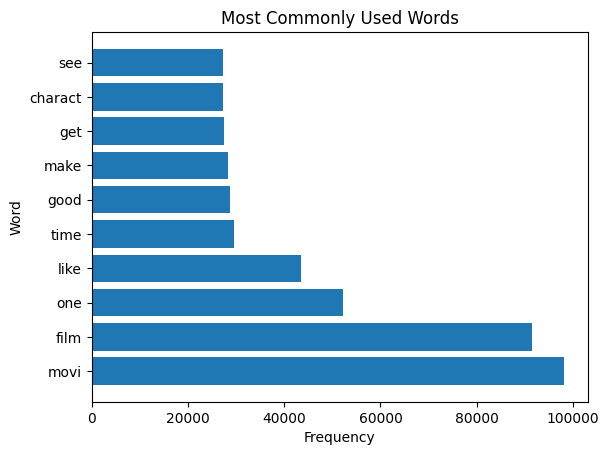

In [41]:
# Create a horizontal bar chart of the most common words
top_words = word_counts.most_common(10)
x_values = [word[1] for word in top_words]
y_values = [word[0] for word in top_words]
plt.barh(y_values, x_values)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Most Commonly Used Words')
plt.show()

**Positive reviews**

In [42]:
#print ten word cloud for positive review words
pos_reviews =  imdb_data[imdb_data.sentiment == 1]
pos_reviews.head(10)

,review,sentiment,word count,new word count
0,one review mention watch 1 oz episod youll hoo...,1,307,168
1,wonder littl product film techniqu unassum old...,1,162,84
2,thought wonder way spend time hot summer weeke...,1,166,86
4,petter mattei love time money visual stun film...,1,230,125
5,probabl alltim favorit movi stori selfless sac...,1,119,58
6,sure would like see resurrect date seahunt ser...,1,150,76
9,like origin gut wrench laughter like movi youn...,1,33,17
14,fantast movi three prison becom famou one acto...,1,50,27
16,film simpli remad one bad film fail captur fla...,1,146,54
18,rememb filmit first film watch cinema pictur d...,1,129,65


In [68]:
count = Counter()  # Initialize a Counter object to hold word counts

# Iterate through each review in the positive reviews DataFrame
for text in pos_reviews['review'].values:
    for word in text.split():  # Split each review into words
        count[word] += 1  # Increment the count for each word

# Get the most common words and their frequencies
most_common_words = count.most_common(50)
print(most_common_words)  # Print the list of most common words

[('film', 48837), ('movi', 42885), ('one', 26834), ('like', 19810), ('time', 15400), ('see', 14624), ('good', 14502), ('stori', 13606), ('charact', 13559), ('make', 13112), ('great', 12719), ('get', 12527), ('watch', 12424), ('love', 12010), ('well', 11257), ('show', 10754), ('realli', 10638), ('also', 10513), ('would', 10320), ('play', 9801), ('scene', 9653), ('even', 9604), ('much', 8971), ('first', 8821), ('end', 8781), ('peopl', 8609), ('way', 8476), ('think', 8327), ('best', 8281), ('go', 8015), ('look', 7855), ('mani', 7524), ('life', 7426), ('work', 7234), ('year', 7229), ('know', 7089), ('made', 6966), ('two', 6851), ('thing', 6824), ('perform', 6821), ('take', 6682), ('seen', 6573), ('dont', 6573), ('act', 6562), ('say', 6539), ('come', 6529), ('littl', 6368), ('man', 6309), ('still', 6295), ('never', 6243)]


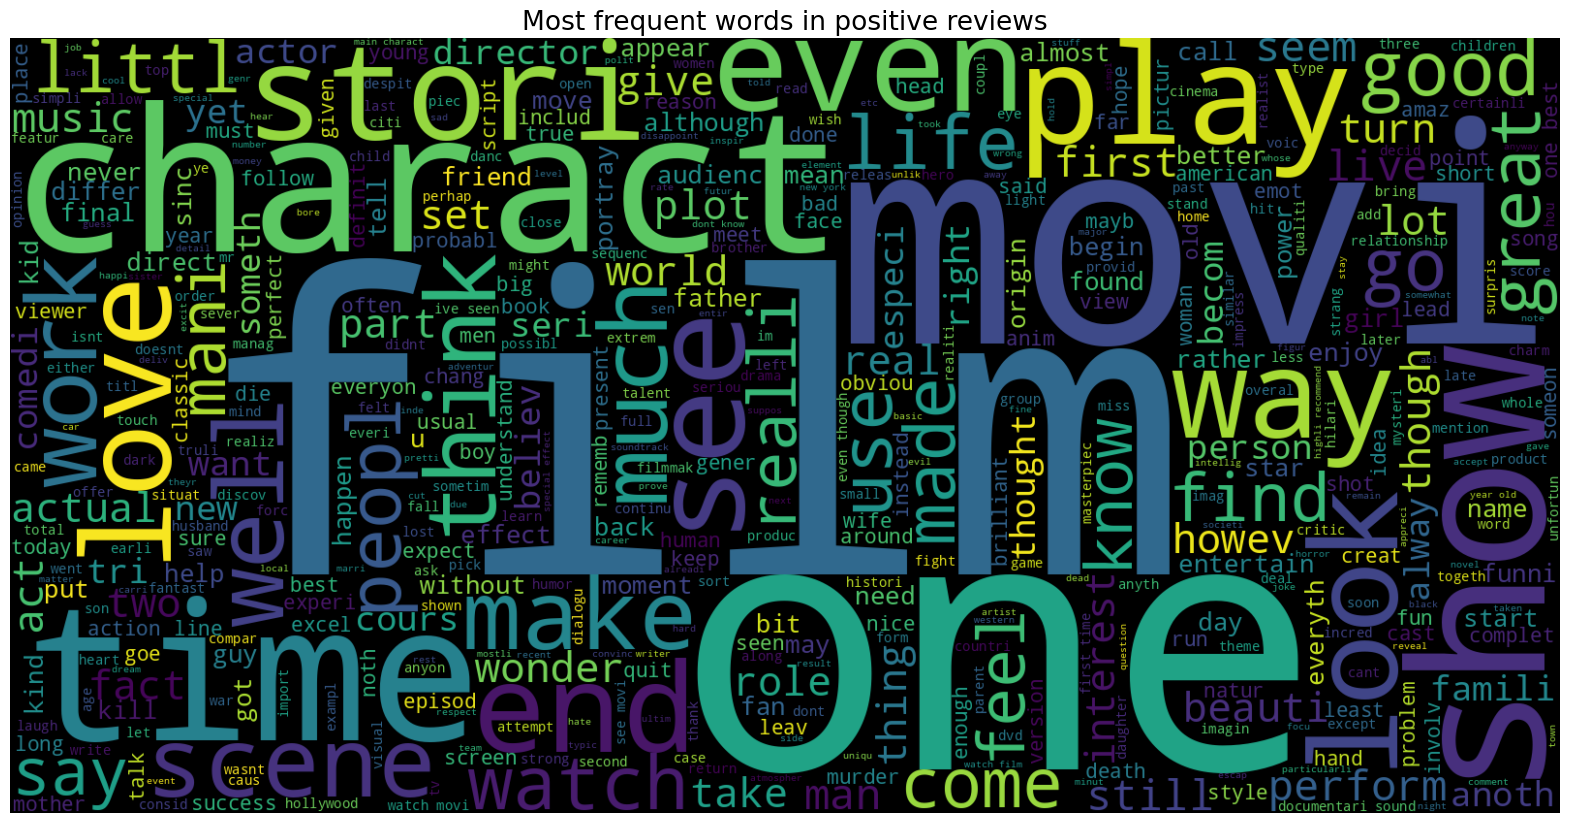

In [44]:
# To Create a word cloud that represent the most common words in positive reviews

text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

**Negative reviews**

In [45]:
#word cloud for negitive review words
neg_reviews =  imdb_data[imdb_data.sentiment == 0]
neg_reviews.head()

,review,sentiment,word count,new word count
3,basic there famili littl boy jake think there ...,0,138,67
7,show amaz fresh innov idea 70 first air first ...,0,174,83
8,encourag posit comment film look forward watch...,0,130,64
10,phil alien one quirki film humour base around ...,0,96,51
11,saw movi 12 came recal scariest scene big bird...,0,180,84


In [69]:
count = Counter()  # Initialize a Counter object to hold word counts

# Iterate through each review in the negative reviews DataFrame
for text in neg_reviews['review'].values:
    for word in text.split():  # Split each review into words
        count[word] += 1  # Increment the count for each word

# Get the most common words and their frequencies
most_common_words = count.most_common(50)
print(most_common_words)  # Print the list of most common words

[('movi', 55288), ('film', 42592), ('one', 25413), ('like', 23646), ('make', 15261), ('get', 14969), ('even', 14933), ('watch', 14382), ('good', 14190), ('time', 14150), ('bad', 13962), ('charact', 13773), ('would', 13480), ('see', 12707), ('realli', 12085), ('look', 11188), ('scene', 10898), ('stori', 10454), ('act', 10036), ('dont', 9912), ('much', 9758), ('go', 9507), ('end', 9218), ('peopl', 9214), ('thing', 9112), ('could', 8918), ('think', 8839), ('show', 8404), ('made', 8300), ('say', 8116), ('plot', 8109), ('way', 7900), ('seem', 7898), ('first', 7869), ('know', 7671), ('well', 7539), ('tri', 7427), ('want', 7084), ('play', 7061), ('actor', 6878), ('also', 6843), ('never', 6488), ('better', 6413), ('seen', 6374), ('come', 6321), ('ever', 6318), ('take', 6091), ('two', 5961), ('littl', 5833), ('work', 5823)]


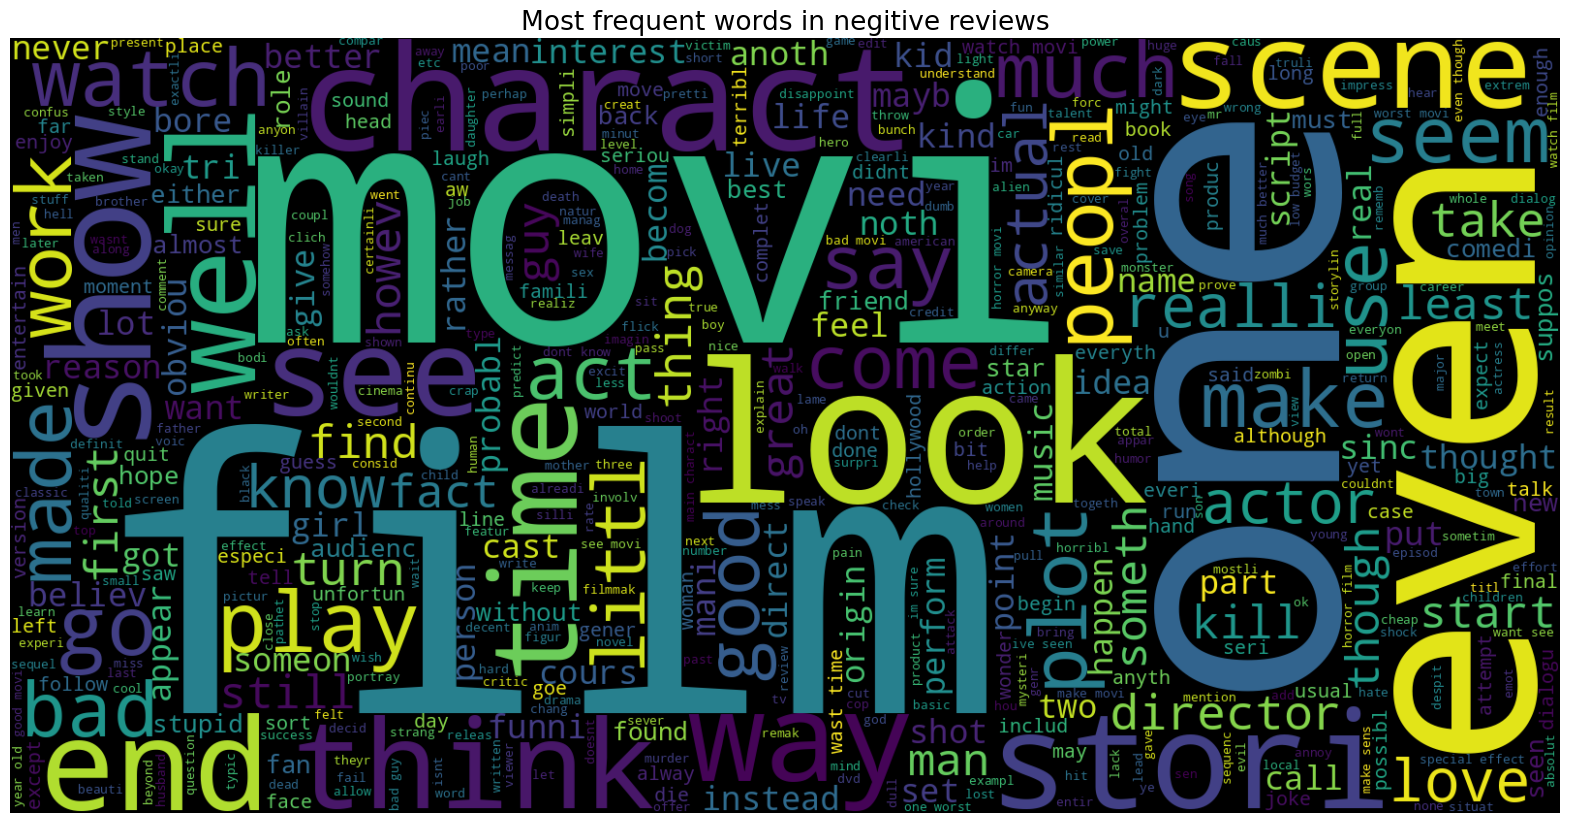

In [48]:
# To Create a word cloud that represent the most common words in negative reviews

text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negitive reviews', fontsize = 19)
plt.show()

# **5.Feature extraction**

 The process of converting raw data into a format that is suitable for machine learning algorithms. This typically involves selecting, modifying, or creating new features from the original data to improve the performance of the model.Here we have text data of sentiment , hence we are using TF-IDF measures

**TF-IDF** stands for Term Frequency-Inverse Document Frequency where:

 TF:Measures how frequently a term appears in a document.

 tf(t,d) = count of term(word) in document / number of words in document

 IDF:Measures how important a term is across the entire corpus.

 idf(t) = log(Num of document/ Num of document in which the word appeared)

 TF-IDF= tf*idf

In [49]:
# Create a TfidfVectorizer object
vect = TfidfVectorizer()

# Fit the vectorizer to the text data and transform it into a matrix of TF-IDF features
x = vect.fit_transform(imdb_data['review'])

# Assign the sentiment labels to the variable y
y = imdb_data['sentiment']

# Print the sizes of the feature matrix and the sentiment labels
print("Size of x: ", (x.shape))
print("Size of y: ", (y.shape))

Size of x:  (49577, 181258)
Size of y:  (49577,)


# **6. Splitting the data into Training and testing dataset**

In [51]:
# Import the necessary library
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (39661, 181258)
Size of y_train:  (39661,)
Size of x_test:  (9916, 181258)
Size of y_test:  (9916,)


# **7.Training Machine Learning model**

Here I have selected two ml models

a.Logistic regression

b.Decision tree classifier

In [52]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

**a. Logistic Regression**

In [53]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)  # Train the model

# Evaluate the model
print("Train score: {:.2f}%".format(lr.score(x_train, y_train) * 100))  # Training accuracy
print("Test score: {:.2f}%".format(lr.score(x_test, y_test) * 100))    # Testing accuracy

# Make predictions
lr_pred = lr.predict(x_test)

# Calculate accuracy
lr_acc = accuracy_score(y_test, lr_pred)
print("Test accuracy: {:.2f}%".format(lr_acc * 100))

Train score: 92.83%
Test score: 88.71%
Test accuracy: 88.71%


In [54]:
# Generate classification report
lr_report = classification_report(y_test, lr_pred, target_names=['Positive', 'Negative'])
print(lr_report)

              precision    recall  f1-score   support

    Positive       0.90      0.87      0.88      4913
    Negative       0.88      0.90      0.89      5003

    accuracy                           0.89      9916
   macro avg       0.89      0.89      0.89      9916
weighted avg       0.89      0.89      0.89      9916



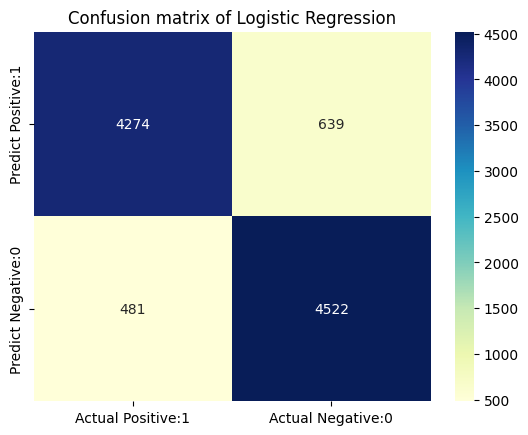

In [55]:
# Define a function for Confusion Matrix
def cm(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                  index=['Predict Positive:1', 'Predict Negative:0'])
  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
  plt.title('Confusion matrix of Logistic Regression')
  plt.show()

# Generate Confusion Matrix
cm(y_test, lr_pred)

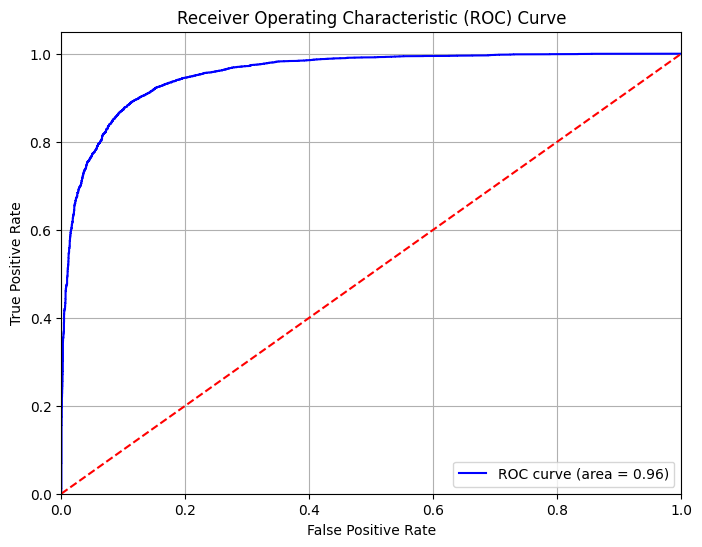

In [59]:
from sklearn.metrics import accuracy_score, roc_curve, auc
# Make predictions
lr_pred_proba = lr.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**b. Decision Tree Classifier**

In [61]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)  # Train the model

# Evaluate the model
print("Train score: {:.2f}%".format(dt.score(x_train, y_train) * 100))  # Training accuracy
print("Test score: {:.2f}%".format(dt.score(x_test, y_test) * 100))    # Testing accuracy

# Make predictions
dt_pred = dt.predict(x_test)

# Calculate accuracy
dt_acc = accuracy_score(y_test, dt_pred)
print("Test accuracy: {:.2f}%".format(dt_acc * 100))

Train score: 100.00%
Test score: 71.62%
Test accuracy: 71.62%


In [65]:
# Make predictions
dt_pred = dt.predict(x_test)

# Generate classification report
dt_report = classification_report(y_test, dt_pred, target_names=['Positive', 'Negative'])
print(dt_report)

              precision    recall  f1-score   support

    Positive       0.71      0.72      0.71      4913
    Negative       0.72      0.72      0.72      5003

    accuracy                           0.72      9916
   macro avg       0.72      0.72      0.72      9916
weighted avg       0.72      0.72      0.72      9916



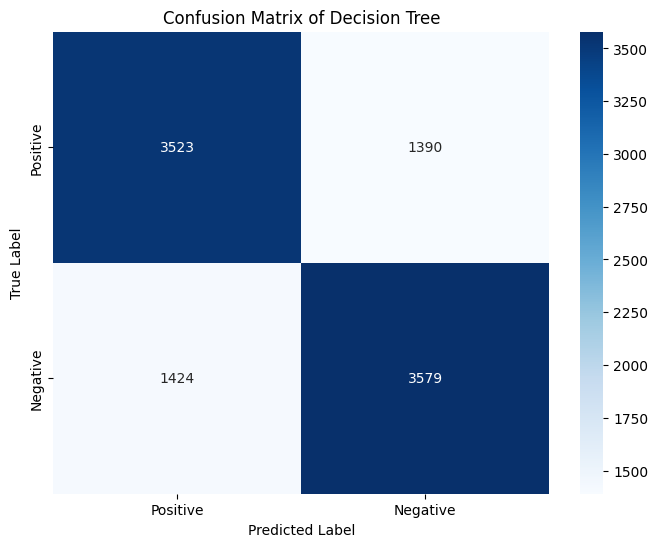

In [67]:
# Generate confusion matrix
cm = confusion_matrix(y_test, dt_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix of Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()